# Movilidad y características de comunas


In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
matplotlib.style.use("fivethirtyeight")

## Load Data

In [2]:
prod_33 = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto33/"
mobility = pd.read_csv(prod_33 + "IndiceDeMovilidad.csv")
mobility["Fecha"] = pd.to_datetime(mobility.Fecha, format="%Y-%m-%d")
mobility['lagged_Fecha'] = mobility['Fecha'] - pd.Timedelta("8d")

print("Fecha min: ", mobility.Fecha.min(), " fecha max: ", mobility.Fecha.max())
mobility.columns

Fecha min:  2020-02-26 00:00:00  fecha max:  2020-05-17 00:00:00


Index(['Region', 'Codigo region', 'Comuna', 'Codigo comuna', 'Superficie_km2',
       'Poblacion', 'IM_interno', 'IM_externo', 'IM', 'Fecha', 'lagged_Fecha'],
      dtype='object')

### Ingresos

Estimación para áreas pequeñas (SAE) 2017

In [5]:
# min_desarrollo = "http://observatorio.ministeriodesarrollosocial.gob.cl/documentos/"


# ingresos = (pd.read_excel(min_desarrollo + 
#     "PLANILLA_Estimaciones_comunales_tasa_pobreza_por_ingresos_multidimensional_2017.xlsx",
#                         skiprows=2)
#            .rename(columns={"Código": "Codigo comuna"}))

In [6]:
#ESTA DATA SALE DEL ETL
ingresos = pd.read_pickle(r'data/data_por_comuna.pkl')

In [7]:
ingresos.head(2)

,comuna,ytotcorh,esc,Codigo comuna,Región,Nombre comuna,Número de personas en situación de pobreza por ingresos,Porcentaje de personas en situación de pobreza por ingresos 2017,Límite inferior,Límite superior,Metodología de Estimación
0,1101,1.231723e+06,13.566768,1101,I de Tarapacá,Iquique,7928,0.043836,0.036953,0.051435,SAE
1,1107,9.365696e+05,12.321213,1107,I de Tarapacá,Alto Hospicio,9847,0.077555,0.068831,0.086089,SAE


#### Education? other variables?

### Merge

In [8]:
mob_cod_comuna = set(mobility['Codigo comuna'].unique())
ingresos_cod_comuna = set(ingresos['Codigo comuna'].unique())
assert len(mob_cod_comuna - ingresos_cod_comuna) < 2 

AssertionError: 

In [9]:
df = pd.merge(mobility, ingresos, how='left', on='Codigo comuna')
df['density'] = df['Poblacion'] / df['Superficie_km2']

## Plots

Text(0.5,1,'Las Condes: Movilidad Interna y Externa')

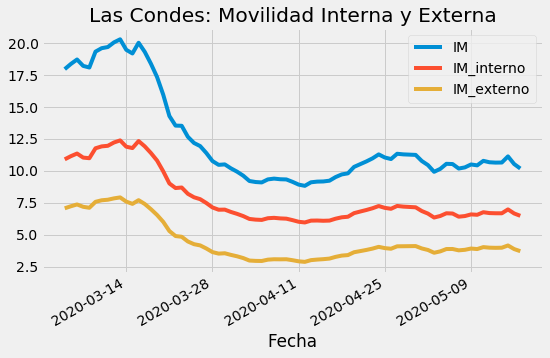

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
(df[df['Comuna'] == 'Las Condes'][['Comuna', 'Fecha', 'IM_interno',
                                            'IM_externo', 'IM']]
.set_index('Fecha')[['IM', 'IM_interno', 'IM_externo']]
 .rolling(8).mean().plot(ax=ax))
ax.set_title("Las Condes: Movilidad Interna y Externa")

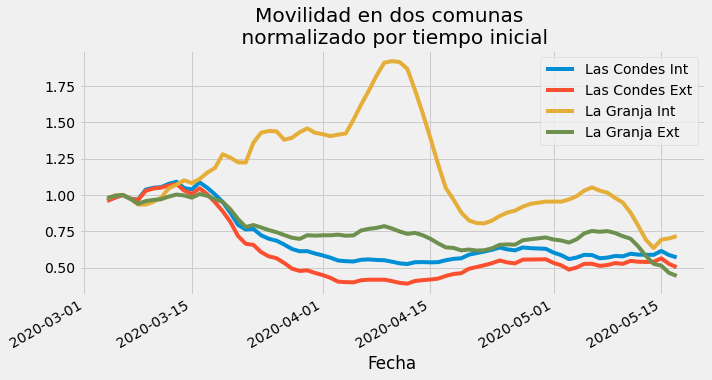

In [40]:
def comparar_dos_comunas(nom_comuna1: str, nom_comuna2: str, df_=df):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    comuna1 = (df_[df_['Comuna'] == nom_comuna1].set_index('Fecha')
     ['IM_interno'].rolling(8).mean())

    (comuna1 / comuna1[9]).plot(ax=ax, label=f"{nom_comuna1} Int")

    comuna1 = (df_[df_['Comuna'] == nom_comuna1].set_index('Fecha')
     ['IM_externo'].rolling(8).mean())
    (comuna1 / comuna1[9]).plot(ax=ax, label=f"{nom_comuna1} Ext")

    comuna2 = (df_[df_['Comuna'] == nom_comuna2].set_index('Fecha')
     ['IM_interno'].rolling(8).mean())
    (comuna2 / comuna2[9]).plot(ax=ax, label=f"{nom_comuna2} Int")

    comuna2 = (df_[df_['Comuna'] == nom_comuna2].set_index('Fecha')
     ['IM_externo'].rolling(8).mean())
    (comuna2 / comuna2[9]).plot(ax=ax, label=f"{nom_comuna2} Ext")
    ax.legend()
    ax.set_title("Movilidad en dos comunas \n normalizado por tiempo inicial");
    
    return fig, ax

comparar_dos_comunas('Las Condes', 'La Granja');

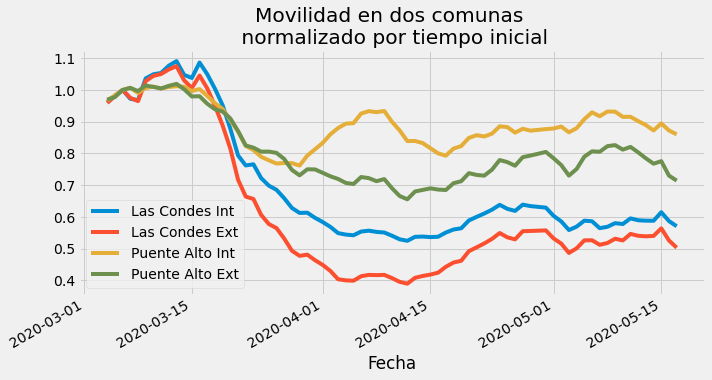

In [21]:
comparar_dos_comunas('Las Condes', 'Puente Alto');

### Scatter plots

+ `mobility_change`: what's the average internal mobility in the second half of the time period?
+ `delta_int_ext`: What the average % difference between internal and external mobility in the second half?

In [82]:
def perc_diff(x, y):
    return 2*(x - y)/(x+y)

def get_mobility_change(comuna_mob):
    n_half = np.ceil(len(comuna_mob) / 2.).astype('int')
    if n_half > 4:
        second_half = np.mean(comuna_mob.values[n_half:])
        first_half = np.mean(comuna_mob.values[0:n_half])
        return perc_diff(second_half, first_half)
    else:
        return np.nan

def get_delta_int_ext(comuna):
    n_half = np.ceil(len(comuna) / 2.).astype('int')
    if n_half > 4:
        mob_int = np.mean(comuna['IM_interno'].values[n_half:])
        mob_ext = np.mean(comuna['IM_externo'].values[n_half:])
        return perc_diff(mob_int, mob_ext)
    else:
        return np.nan

def create_changes_df(df_):
    mobility_change = (df_.groupby("Codigo comuna")
                       ['IM_interno'].apply(get_mobility_change))
    mobility_change.name = 'mobility_change'
    delta_int_ext = (df_.groupby("Codigo comuna")
                       .apply(get_delta_int_ext))
    delta_int_ext.name = 'delta_int_ext'

    porc_pobreza = (df_.groupby('Codigo comuna')
        ['Porcentaje de personas en situación de pobreza por ingresos 2017']
                   .mean())
    porc_pobreza.name = "porc_pobreza"

    changes = pd.concat([mobility_change, delta_int_ext,
                        porc_pobreza], axis=1)
    return changes

changes_country = create_changes_df(df)

/usr/local/anaconda3/envs/spike_basicoV6/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Comunas en Chile \n % de cambio de movilidad vs porc pobreza')

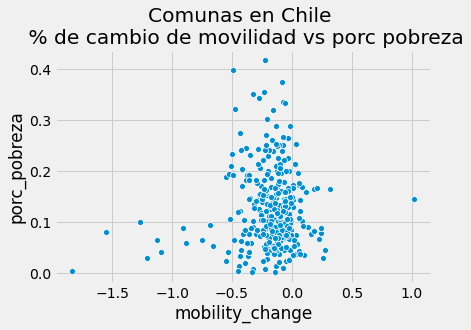

In [94]:
ax = sns.scatterplot(x="mobility_change", y="porc_pobreza", 
                     data=changes_country)
ax.set_title("Comunas en Chile \n % de cambio de movilidad vs porc pobreza")

Text(0.5, 1.0, 'Comunas en Chile \n % de diff entre mobilidad externa e interna vs porc pobreza')

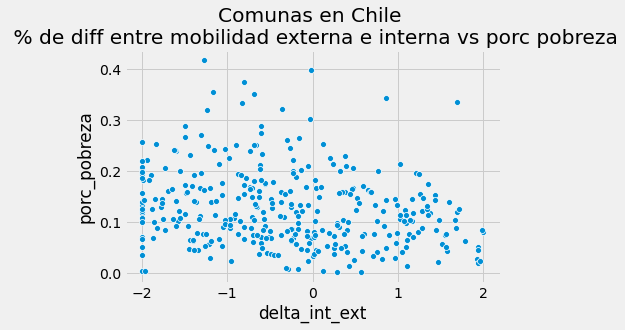

In [84]:
ax = sns.scatterplot(x="delta_int_ext", y="porc_pobreza",
                     data=changes_country)
ax.set_title("Comunas en Chile \n % de diff entre movilidad externa e interna vs porc pobreza")

In [86]:
metropolitana = df.query("Region == 'Metropolitana de Santiago' ")

changes_metropolitana = create_changes_df(metropolitana)

/usr/local/anaconda3/envs/spike_basicoV6/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Comunas en RM \n % de cambio de movilidad vs porc pobreza')

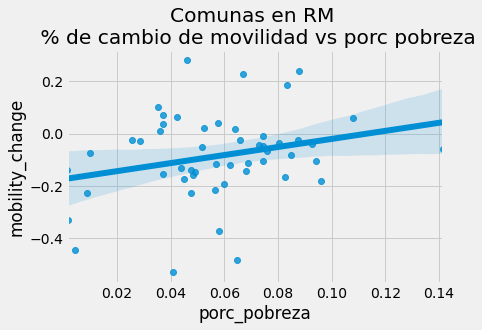

In [95]:
type_ = "regresion"
if type_ == "regression":
    plot_function = sns.scatterplot
else:
    plot_function = sns.regplot
    
ax = plot_function(x="porc_pobreza", y="mobility_change", 
                     data=changes_metropolitana)
ax.set_title("Comunas en RM \n % de cambio de movilidad vs porc pobreza")

Text(0.5, 1.0, 'Comunas en RM \n % de diff entre mobilidad externa e interna vs porc pobreza')

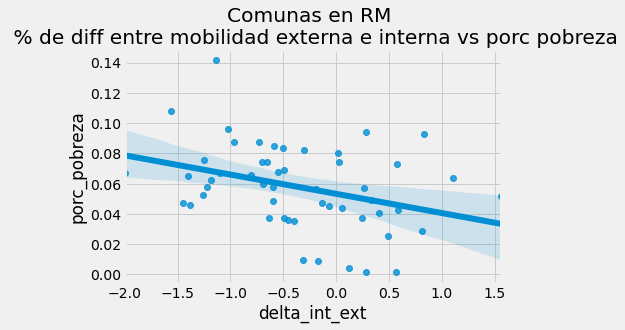

In [93]:
ax = plot_function(x="delta_int_ext", y="porc_pobreza",
                     data=changes_metropolitana)
ax.set_title("Comunas en RM \n % de diff entre movilidad externa e interna vs porc pobreza")

In [98]:
metropolitana.Comuna.nunique()

52